# Building an AI Agent for Medical Image Classification with MedImageInsight

This tutorial demonstrates how to build an intelligent conversational agent that can classify medical images using MedImageInsight embeddings. The agent uses Semantic Kernel to coordinate natural language interactions with image classification capabilities, allowing users to ask questions about medical images in plain language.

## Prerequisites

Before proceeding with this tutorial, you need to perform some initial setup.

### Required Models

This notebook requires the following:
- **MedImageInsight** (MI2)
- **Azure OpenAI** (GPT-4o, GPT-4.1 or GPT-5)

### Setup

Follow the [Getting Started](../../README.md#getting-started) instructions in the main README to:
1. Deploy the required models
2. Set up your environment with the `.env` file
3. Install the Healthcare AI Toolkit
4. Download sample data

Additionally, install Semantic Kernel:
```bash
pip install semantic-kernel
```

## Architecture

The agent architecture consists of several key components:

1. **DataAccess**: Manages storage and retrieval of images by unique IDs
2. **ChatContext**: Coordinates conversation flow and data management
3. **ImageClassificationPlugin**: Integrates MedImageInsight for classification
4. **ChatCompletionAgent**: Orchestrates LLM-based natural language understanding

The workflow is as follows:
- User sends a message with an attached image
- Image is stored and assigned a unique ID
- Agent processes the natural language query
- Agent calls the classification plugin with extracted labels
- Plugin computes embeddings and similarity scores
- Results are returned to the user in natural language

## 1. Setup and Import Required Libraries

In [1]:
from semantic_kernel import Kernel
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.functions import kernel_function
from semantic_kernel.agents import ChatCompletionAgent
from typing import Annotated
import uuid


## 2. Chat Context Management and Data Access Layer

The `ChatContext` and `DataAccess` classes form the architectural foundation of our agent system. Together, they solve a fundamental challenge: **how to coordinate stateful conversations with binary image data when agents can only pass text between function calls**.

### The Architecture Challenge

When building conversational agents with Semantic Kernel, all function parameters must be serializable to JSON for the language model to process. This creates a problem for medical imaging applications:
- Images are binary data (bytes) that cannot be directly passed through text-based interfaces
- Multiple function calls need access to the same image data
- Expensive resources (like the MI2 client) should be initialized once and shared across all interactions

**Important:** This is **not** a typical multi-modal approach where images are sent directly to the LLM for vision-based understanding. Instead, images are routed to the MedImageInsight classification tool. The LLM only processes text—it understands the user's intent and extracts classification labels, then calls the appropriate function with an image ID reference.

### The Solution: Context + Data Access Pattern

We separate concerns into two complementary classes:

**`DataAccess`** - Handles the storage/retrieval problem:
1. Stores image bytes in memory (or database/blob storage in production)
2. Generates unique text identifiers (UUIDs) for each image
3. Allows functions to retrieve images using these text IDs
4. Provides state management (list, store, retrieve operations)

**`ChatContext`** - Handles the orchestration problem:
1. Coordinates the three critical components: DataAccess, MI2 Client, and Agent
2. Maintains shared state across the entire conversation
3. Provides a high-level interface (`send_message`) that abstracts complexity
4. Handles image format conversion (file paths, PIL Images, bytes) automatically

### How They Work Together

The workflow follows these steps:

1. **User sends image** → `ChatContext.send_message()` receives the image and message
2. **Image conversion** → ChatContext converts the image to bytes (from file path, PIL Image, etc.)
3. **Image storage** → `DataAccess.store_image()` stores the bytes and generates a unique ID (e.g., "abc123")
4. **Message preparation** → ChatContext appends the image ID to the user's message: `"Is this pneumonia?\nImage ID: abc123"`
5. **Agent processing** → The Agent (LLM) receives only text—no binary data. It understands the question and extracts labels
6. **Function call** → Agent invokes `classify_image(labels=["pneumonia", "normal"], image_id="abc123")`
7. **Image retrieval** → Plugin calls `DataAccess.get_image("abc123")` to retrieve the actual image bytes
8. **Classification** → Plugin sends bytes to MedImageInsight for embedding and similarity calculation
9. **Results** → Probabilities are returned to the agent, which formats them for the user

**Key point:** The image travels through a separate path (ChatContext → DataAccess → Plugin → MI2) while the LLM only sees text references (image IDs) and orchestrates the workflow.

### Production Considerations

In production systems, replace the in-memory `DataAccess._images` dictionary with:
- Azure Blob Storage for large-scale deployments
- Redis or another caching layer for distributed systems
- Database storage with proper indexing for audit trails

The architectural pattern remains the same—only the storage backend changes.

In [2]:
class DataAccess:
    """Stores and retrieves images by ID."""
    
    def __init__(self):
        self._images = {}
    
    def store_image(self, image: bytes) -> str:
        """Store an image and return its ID."""
        image_id = str(uuid.uuid4())[:6]
        self._images[image_id] = image
        return image_id
    
    def get_image(self, image_id: str) -> bytes:
        """Retrieve an image by ID."""
        if image_id in self._images:
            return self._images.get(image_id)
        print(f"Image ID {image_id} not found!")

    def list_images(self):
        """List all stored image IDs."""
        return list(self._images.keys())


In [ ]:
from healthcareai_toolkit.clients import MedImageInsightClient
from typing import Union
from pathlib import Path
from PIL import Image
from IPython.display import display
import io

def print_message(header, message):
    agent_header = f" {header.strip()} "
    print(f"{agent_header:-^50}")
    print(message)
    print("-" * 50)
    print()

class ChatContext:
    """Manages conversation context and data access."""
    
    def __init__(self, data_access = None, mi2_client = None):
        self.agent = None
        self.data_access = data_access or DataAccess()
        self.mi2_client = mi2_client or MedImageInsightClient()
    
    def set_agent(self, agent: ChatCompletionAgent):
        """Set the agent after initialization."""
        self.agent = agent

    async def send_message(self, message: str, image: Union[bytes, str, Path, Image.Image] = None):
        """Send a message with optional image to the agent.
        
        Args:
            message: The text message to send
            image: Can be bytes, file path (str/Path), or PIL Image
        """
        
        if self.agent is None:
            raise ValueError("Agent not set. Call set_agent() first.")
        
        if image is not None:
            # Convert image to bytes
            if isinstance(image, (str, Path)):
                with open(image, "rb") as f:
                    image_bytes = f.read()
            elif isinstance(image, Image.Image):
                buffer = io.BytesIO()
                image.save(buffer, format=image.format or 'PNG')
                image_bytes = buffer.getvalue()
            elif isinstance(image, bytes):
                image_bytes = image
            else:
                raise TypeError(f"Unsupported image type: {type(image)}")
            
            display_image = Image.open(io.BytesIO(image_bytes))
            display(display_image)
            
            # Store image and get ID
            image_id = self.data_access.store_image(image_bytes)
            full_message = f"{message}\nImage ID: {image_id}"
        else:
            full_message = message

        # Print user message        
        print_message("User", full_message)

        # Send to agent
        agent_header = f" Agent ({self.agent.name}) "
        async for response in self.agent.invoke(full_message):
            print_message(agent_header, response)


In [4]:
# TODO: Move to package or somewhere else.

import re

def extract_openai_info(endpoint_url):
    match = re.search(r'(https://[^/]+)/openai/deployments/([^/]+)/.*api-version=([^&]+)', endpoint_url)
    if match:
        endpoint = match.group(1)  # This includes https://
        deployment = match.group(2)
        api_version = match.group(3)
        model = deployment
        return {
            'endpoint': endpoint,
            'deployment': deployment, 
            'model': model,
            'api_version': api_version
        }


## 4. Initialize Semantic Kernel

Here we initialize the Semantic Kernel and configure it with Azure OpenAI services. The kernel acts as the central orchestrator for our agent, managing:
- AI service connections
- Plugin registration
- Function execution

We load configuration from the environment settings managed by the healthcare AI toolkit.

In [5]:
from healthcareai_toolkit import settings

openai_info = extract_openai_info(settings.AZURE_OPENAI_ENDPOINT)


# Initialize kernel
kernel = Kernel()

# Add Azure OpenAI service
kernel.add_service(
    AzureChatCompletion(
        endpoint=openai_info['endpoint'],
        api_key=settings.AZURE_OPENAI_API_KEY,
        deployment_name=openai_info['deployment'],
        api_version=openai_info['api_version']
    )
)


## 5. Image Classification Plugin

The `ImageClassificationPlugin` is the core component that integrates MedImageInsight with the agent framework. It performs zero-shot classification using the same embedding-based approach described in the [zero-shot classification tutorial](./zero-shot-classification.ipynb).

### How It Works

1. **Embedding Generation**:
   - `_get_image_embeddings()`: Converts image bytes to feature vectors using MedImageInsight
   - `_get_text_embeddings()`: Converts text labels to feature vectors

2. **Similarity Calculation**:
   - Computes dot product between image and text embeddings
   - Applies learned temperature scaling factor
   - Uses softmax to convert logits to probabilities

3. **Agent Integration**:
   - The `@kernel_function` decorator exposes `classify_image()` to the agent
   - Type annotations provide clear parameter documentation for the LLM
   - Returns a dictionary mapping categories to probability scores

In [ ]:
from typing import List
import torch
import numpy as np


class ImageClassificationPlugin:
    """Plugin that classifies images."""
    
    def __init__(self, chat_context: ChatContext):
        self.chat_context = chat_context
        self.data_access = chat_context.data_access
        self.mi2_client = chat_context.mi2_client
        self.scaling_factor = np.atleast_1d(self.mi2_client.submit(text_list=["placeholder"])[0]['scaling_factor'])


    def _get_image_embeddings(self, image_data: bytes):
        """Get image embeddings using MedImageInsightClient."""
        response = self.mi2_client.submit(image_list=[image_data])
        return np.array(response[0]['image_features'][0])
    
    def _get_text_embeddings(self, texts: List[str]):
        """Get text embeddings using MedImageInsightClient."""
        response = self.mi2_client.submit(text_list=texts)
        return np.array([item["text_features"] for item in response])


    def _calculate_probability(self, image_features: np.ndarray, text_features: np.ndarray, texts: List[str]):
        """Calculate probability scores between image and text embeddings."""

        logits_per_image = (
            torch.from_numpy(self.scaling_factor).exp()
            * torch.from_numpy(image_features)
            @ torch.from_numpy(text_features).t()
        )
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        return {text: float(prob) for text, prob in zip(texts, probs)}

    @kernel_function(
        name="classify_image",
        description="Classifies an image against a list of categories and returns probabilities"
    )
    def classify_image(
        self,
        labels: Annotated[list[str], "List of category labels"],
        image_id: Annotated[str, "Image ID to classify"]
    ) -> Annotated[dict, "Categories mapped to probability scores"]:
        """Classifies an image against provided categories."""

        # Get image from data access
        image_data = self.data_access.get_image(image_id)
        
        if image_data is None:
            return {"error": f"Image {image_id} not found"}
        
        print_message("Tool (classify_image)", f"Classifying image {image_id} ({len(image_data)} bytes).\nLabels: {labels}")

        image_features = self._get_image_embeddings(image_data)
        text_features = self._get_text_embeddings(labels)

        # Calculate probabilities
        probabilities = self._calculate_probability(image_features, text_features, labels)
        
        return probabilities


## 6. Create and Configure the Agent

Now we bring all the components together to create our medical image classification agent.

### Agent Instructions

The agent is configured with detailed instructions that define its behavior:
- How to extract and format classification labels from user queries
- When and how to call the classification plugin
- How to present results to users
- Example interactions to guide the agent's responses

#### Label Format

For optimal results, text labels should follow this hierarchical structure:
```
<modality> <body part> <view information> <pathology/condition>
```

Examples:
- "x-ray chest anteroposterior pneumonia"
- "computed tomography chest axial mass"
- "magnetic resonance imaging brain sagittal tumor"

### Initialization Steps

1. Create the chat context
2. Instantiate the classification plugin with the context
3. Register the plugin with the kernel
4. Create the agent with the kernel and instructions
5. Link the agent back to the context

This design allows for clean separation of concerns while maintaining necessary connections between components.

In [7]:
context = ChatContext()

plugin = ImageClassificationPlugin(context)
# Add plugin to kernel with context's data access
kernel.add_plugin(
    plugin, 
    plugin_name="ImageClassifier"
)

# Create agent
agent = ChatCompletionAgent(
    kernel=kernel,
    name="ImageClassificationAgent",
    instructions="""
You are a medical image classification assistant that helps classify medical images.

When a user provides a message with an Image ID:
1. Extract the categories from their message as a list of strings
2. Each category should follow increasing specificity when possible: <modality> <body part> <view information> <pathology/condition>
3. If any component is not available or not specified, leave it out
4. Call classify_image with the labels and the image_id
5. Report the probabilities to the user in a clear format

Label Format Examples:
- "x-ray chest anteroposterior atelectasis"
- "x-ray chest anteroposterior pneumonia"
- "computed tomography chest axial mass"
- "magnetic resonance imaging knee sagittal torn meniscus"
- "histopathology H&E stain sentinel lymph node malignant"
- "retinal fundus pathological myopia"
- "dermatology clinical photography angular cheilitis"
- "x-ray chest pneumonia" (when view information not specified)
- "chest x-ray" (when only modality and body part known)

If the user provides abbreviated or informal labels (e.g., "CT chest with mass", "MRI brain tumor"), expand them.
If the user asks general questions, help them formulate appropriate medical imaging labels.

Example:
User: "is this atelectasis or pneumonia?\nImage ID: abc123"
You: Call classify_image(labels=["x-ray chest anteroposterior atelectasis", "x-ray chest anteroposterior pneumonia"], image_id="abc123")
""".strip(),
)

# Set the agent in the context
context.set_agent(agent)


## 7. Example: Classify a Medical Image

Now let's test our agent with a real medical image. In this example, we'll:
1. Load a chest X-ray image
2. Display it for visual reference
3. Ask the agent to classify it among several possible conditions

The agent will:
- Understand the natural language query
- Extract the relevant classification labels
- Call the classification plugin
- Return probability scores for each condition

### Try Your Own Images

You can easily adapt this example to classify your own medical images by:
- Changing the `input_image` path
- Modifying the question to include relevant conditions
- Using different medical imaging modalities (CT, MRI, etc.)

### Understanding the Results

The agent will return probability scores for each label. Higher probabilities indicate stronger similarity between the image and that particular condition description in the MedImageInsight embedding space.

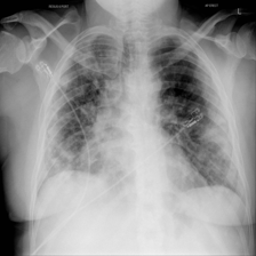

---------------------- User ----------------------
Is this a chest x-ray showing COVID-19, pneumonia, or atelectasis?
Image ID: 246e45
--------------------------------------------------

------------- Tool (classify_image) --------------
Classifying image 246e45 (29473 bytes).
Labels: ['x-ray chest COVID-19', 'x-ray chest pneumonia', 'x-ray chest atelectasis']
--------------------------------------------------

-------- Agent (ImageClassificationAgent) --------
Here are the classification probabilities for Image ID 246e45:
- x-ray chest COVID-19: 0.845
- x-ray chest pneumonia: 0.155
- x-ray chest atelectasis: 0.00022

Interpretation:
- The model most strongly favors COVID-19 changes on chest x-ray.
- Pneumonia is less likely but possible.
- Atelectasis is very unlikely.

Note: Radiographic appearances can overlap; final diagnosis should consider clinical context (symptoms, PCR/antigen testing, labs) and, if needed, additional imaging.
--------------------------------------------------


In [ ]:
import os

input_image = os.path.join(settings.DATA_ROOT, "segmentation-examples/covid_1585.png")

# Send message with image
await context.send_message(
    message="Is this a chest x-ray showing COVID-19, pneumonia, or atelectasis?",
    image=input_image
)


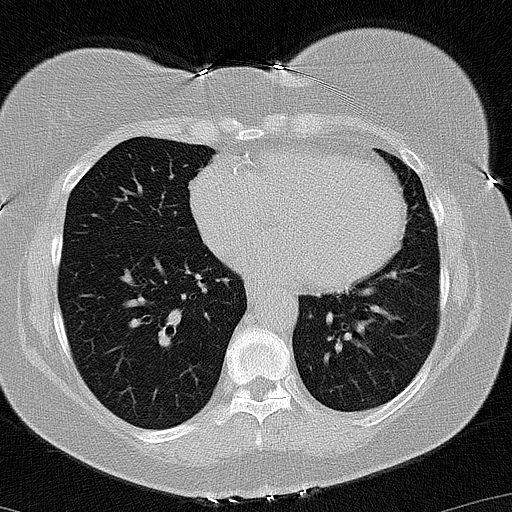

---------------------- User ----------------------
Could you tell me what modality this image is (CT, MRI, XRAY, mammography)
and what body part (extremity, chest, abdomen, brain, spine, pelvis, breast)?
Image ID: 75fbb5
--------------------------------------------------

------------- Tool (classify_image) --------------
Classifying image 75fbb5 (375461 bytes).
Labels: ['computed tomography', 'magnetic resonance imaging', 'x-ray', 'mammography']
--------------------------------------------------

------------- Tool (classify_image) --------------
Classifying image 75fbb5 (375461 bytes).
Labels: ['extremity', 'chest', 'abdomen', 'brain', 'spine', 'pelvis', 'breast']
--------------------------------------------------

-------- Agent (ImageClassificationAgent) --------
Here are the classification probabilities for Image ID 75fbb5:

Modality
- computed tomography: 99.935%
- mammography: 0.055%
- magnetic resonance imaging: 0.005%
- x-ray: 0.004%

Body part
- chest: 98.373%
- breast: 0.831

In [11]:
input_image = os.path.join(settings.DATA_ROOT, "medimageinsight-outlier-detection/samples/test/outlier/CT/1.3.6.1.4.1.55648.010293352392778028677215985701318018213/1.3.6.1.4.1.55648.010293352392778028677215985701318018213.3.png")
message="Could you tell me what modality this image is (CT, MRI, XRAY, mammography)\n" + \
        "and what body part (extremity, chest, abdomen, brain, spine, pelvis, breast)?"

# Send message with image
await context.send_message(
    message=message,
    image=input_image
)


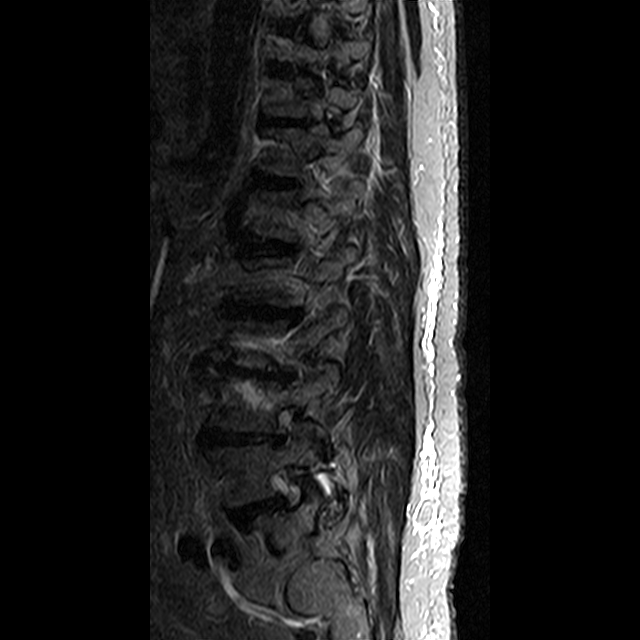

---------------------- User ----------------------
Could you tell me what modality this image is (CT, MRI, XRAY, mammography) and what body part (extremity, chest, abdomen, brain, spine, pelvis, breast)?
Image ID: 3ea26b
--------------------------------------------------

------------- Tool (classify_image) --------------
Classifying image 3ea26b (212636 bytes).
Labels: ['x-ray', 'computed tomography', 'magnetic resonance imaging', 'mammography']
--------------------------------------------------

------------- Tool (classify_image) --------------
Classifying image 3ea26b (212636 bytes).
Labels: ['extremity', 'chest', 'abdomen', 'brain', 'spine', 'pelvis', 'breast']
--------------------------------------------------

-------- Agent (ImageClassificationAgent) --------
Here are the classification probabilities for Image ID: 3ea26b

Modality:
- Magnetic resonance imaging (MRI): 99.34%
- Computed tomography (CT): 0.56%
- X-ray: 0.09%
- Mammography: 0.01%

Body part:
- Spine: 99.81%
- Brain

In [10]:
input_image = os.path.join(settings.DATA_ROOT, "medimageinsight-outlier-detection/samples/test/outlier/MR/1.3.6.1.4.1.55648.002676776301544845833524448635393145729/1.3.6.1.4.1.55648.002676776301544845833524448635393145729.502.png")

# Send message with image
await context.send_message(
    message=message,
    image=input_image
)


## Conclusion

This tutorial demonstrated how to build an AI agent that combines natural language understanding with medical image classification using MedImageInsight embeddings. By leveraging Semantic Kernel, we created an intuitive conversational interface that allows users to ask questions about medical images in plain language without needing to understand the underlying technical implementation.

The key advantage of this approach is flexibility—the agent can adapt to different classification tasks through natural conversation, making it valuable for:
- **Rapid prototyping** of classification workflows without writing new code
- **Clinical decision support** where physicians can ask specific diagnostic questions
- **Research exploration** to quickly test hypotheses across different pathology categories
- **Educational applications** where students can learn through interactive questioning

## Next Steps

### Creating Different Types of Agents

Now that you understand the fundamentals, you can create different types of specialized agents by combining concepts from other notebooks:

**Adapter-Enhanced Classification Agents** - Use the [adapter training approach](./adapter-training.ipynb) to build agents with fine-tuned classification layers on top of embeddings. This can significantly boost accuracy for specific tasks like pneumonia detection or tumor classification while maintaining the conversational interface.

**Segmentation + Classification Agents** - Integrate [MedImageParse](../medimageparse/medimageparse_segmentation_demo.ipynb) to create agents that provide both classification and visual localization. These agents could answer questions like "Where is the lesion?" by highlighting affected regions alongside classification probabilities.

**Quality Control Agents** - Incorporate the [outlier detection methods](./outlier-detection-demo.ipynb) to create agents that flag unusual cases, detect acquisition problems, or identify studies that deviate from expected protocols—essential for maintaining data quality in clinical and research settings.

**Multi-Modal Diagnostic Agents** - Combine multiple data types using patterns from the [advanced demos](../advanced_demos/). For example, build agents that analyze radiology images, pathology slides, and clinical notes together for comprehensive diagnostic support in complex cases like cancer staging.

### Multi-Agent Orchestration with Healthcare Agent Orchestrator

For production scenarios requiring coordination between multiple specialized agents, explore the [**Healthcare Agent Orchestrator**](https://github.com/Azure-Samples/healthcare-agent-orchestrator/) (HAO) project. HAO is a multi-agent framework specifically designed for complex healthcare workflows where different agents need to collaborate and share context.

HAO demonstrates how to:
- **Coordinate multiple specialized agents** working together on complex tasks like cancer care coordination
- **Integrate with Microsoft Teams** for real-time collaboration between AI agents and care teams
- **Work across diverse data types** including imaging, pathology, clinical notes, and structured data
- **Build modular, scalable solutions** where agents can be added or modified without disrupting the overall system
- **Connect with enterprise systems** like Copilot Studio through Microsoft Cloud for Healthcare

This is particularly valuable for multi-disciplinary scenarios where a classification agent might work alongside report generation agents, scheduling agents, and care coordination agents—all collaborating to support the clinical team.

### Related Notebooks

- [Zero-Shot Classification](./zero-shot-classification.ipynb) - Deep dive into the embedding-based classification approach
- [Adapter Training](./adapter-training.ipynb) - Fine-tune for improved accuracy on specific tasks
- [Outlier Detection](./outlier-detection-demo.ipynb) - Identify unusual cases automatically
- [Advanced Demos](../advanced_demos/) - Multi-modal and complex healthcare applications